In [1]:
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
data_folder = Path().absolute() / "../data/processed/"
file_name = "processed_df.csv"

# check file size
file_size_bytes = (data_folder / file_name).stat().st_size
print(f"The file size in bytes is: {file_size_bytes: 1G}")

The file size in bytes is:  2.89454E+06


In [2]:
df = pd.read_csv(
    data_folder / file_name,
    parse_dates=["DateTime"],
    )
df.head(10)

,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,DateTime,Year,Month,Hour,meridian
0,Saturday,LAWRENCE EAST STATION,SRDP,0,0,N,SRT,3023,2022-01-01 15:59:00,2022,1,15,PM
1,Saturday,SPADINA BD STATION,MUIS,0,0,NaN,BD,0,2022-01-01 02:23:00,2022,1,2,AM
2,Saturday,KENNEDY SRT STATION TO,MRO,0,0,NaN,SRT,0,2022-01-01 22:00:00,2022,1,22,PM
3,Saturday,VAUGHAN MC STATION,MUIS,0,0,NaN,YU,0,2022-01-01 02:28:00,2022,1,2,AM
4,Saturday,EGLINTON STATION,MUATC,0,0,S,YU,5981,2022-01-01 02:34:00,2022,1,2,AM
5,Saturday,QUEEN STATION,MUNCA,0,0,NaN,YU,0,2022-01-01 05:40:00,2022,1,5,AM
6,Saturday,DAVISVILLE STATION,MUNCA,0,0,NaN,YU,0,2022-01-01 06:56:00,2022,1,6,AM
7,Saturday,ST PATRICK STATION,MUNCA,0,0,NaN,YU,0,2022-01-01 06:58:00,2022,1,6,AM
8,Saturday,PAPE STATION,MUNCA,0,0,NaN,BD,0,2022-01-01 07:01:00,2022,1,7,AM
9,Saturday,WILSON STATION,TUATC,10,0,S,YU,5896,2022-01-01 07:43:00,2022,1,7,AM


In [3]:
def calculate_metrics(sub_category: pd.DataFrame) -> pd.Series:
    """Function used to calculate subway delay metrics.

    Args:
        sub_category (pd.DataFrame): Sub category from a given column.

    Returns:
        pd.Series: Series of metrics used for data analysis.
    """
    metrics = {}
    no_delay_count = sub_category[sub_category["Min Delay"] == 0].shape[0]
    total_service_count = sub_category.shape[0]

    # return 0 if there are no on-time services
    if no_delay_count == 0:
        sub_category["on_time_perc_performance"] = 0.0

    metrics["on_time_perc_performance"] = no_delay_count * 100 / total_service_count
    metrics["total_service_count"] = total_service_count
    metrics["total_delay"] = sub_category["Min Delay"].sum()

    return pd.Series(metrics)

### Calculate each category and flag categories of concern

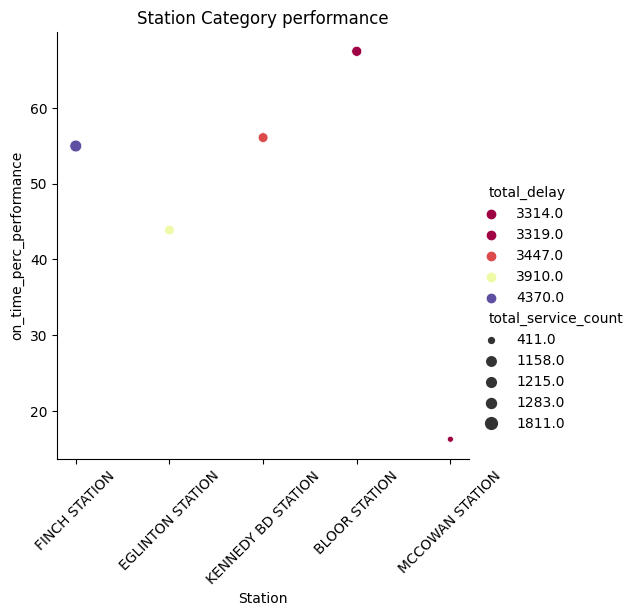

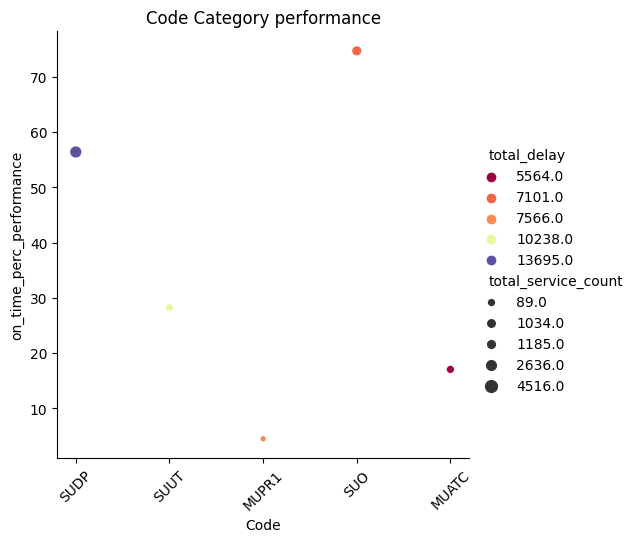

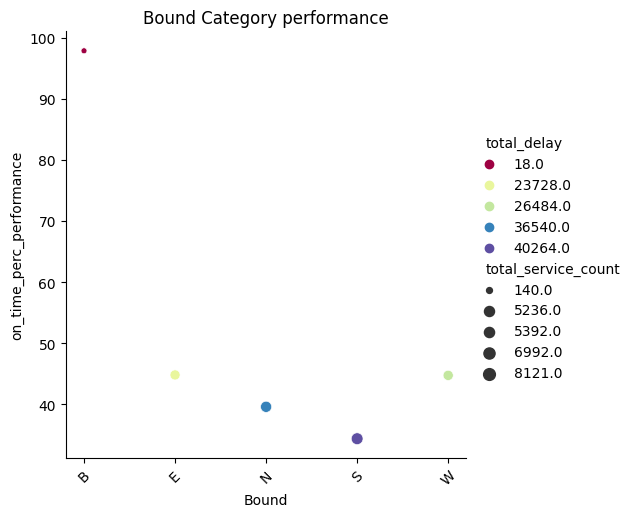

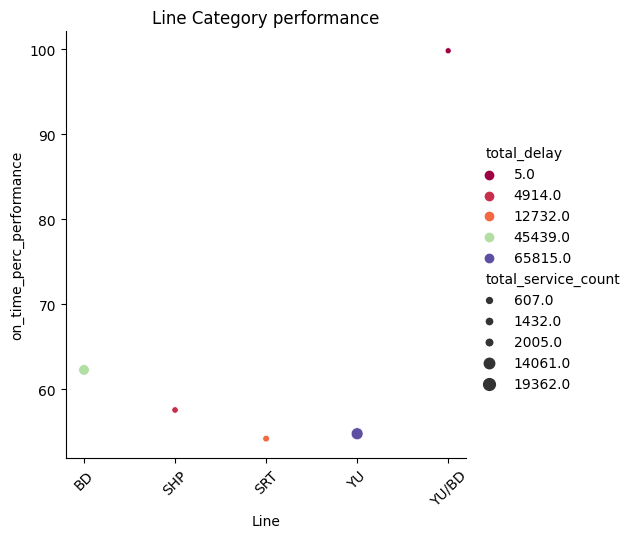

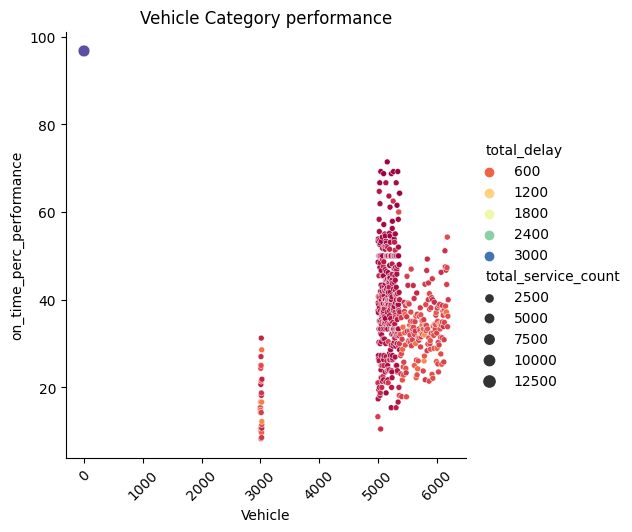

In [4]:
categories = ["Station", "Code", "Bound", "Line", "Vehicle"]
all_delayed_categories = {}
for category in categories:
    temp = df.groupby(category).apply(calculate_metrics)

    # remove any categories that have no delays
    # total service of more than 10
    # and do not plot any services that have 100% service
    temp = temp[
        (temp["total_delay"] > 0.) &
        (temp["total_service_count"] > 10) &
        (temp["on_time_perc_performance"] < 100.)
        ]
    if category in ["Station", "Code"]:
        # keep only top 5 worst performing stations and code
        temp = temp.sort_values("total_delay", ascending=False).head(5)
    all_delayed_categories[category] = temp
    sns.relplot(temp.reset_index(), x=category, y="on_time_perc_performance", size="total_service_count", hue="total_delay", palette="Spectral")
    plt.xticks(rotation=45)
    plt.title(f"{category} Category performance")
    plt.show()

# Conclusion